 # DANN for ST

 Creating something like CellDART but it actually follows Adda in PyTorch as a first step

In [1]:
import math
import os
import datetime
from copy import deepcopy
from itertools import count
import warnings

from tqdm.autonotebook import tqdm
import matplotlib.pyplot as plt
import h5py
import pickle
import numpy as np


import torch
from torch.nn import functional as F
from torch import nn
from torch.cuda.amp import GradScaler
from torch import autocast

from src.da_models.autoencoder import AutoEncoder
from src.da_models.datasets import SpotDataset
from src.da_models.utils import set_requires_grad
from src.da_models.utils import initialize_weights
from src.utils.dupstdout import DupStdout


# datetime object containing current date and time
script_start_time = datetime.datetime.now().strftime("%Y-%m-%d_%Hh%Mm%S")


/tmp/ipykernel_408076/2837532926.py:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
if device == "cpu":
    warnings.warn("Using CPU", stacklevel=2)


In [3]:
TRAIN_USING_ALL_ST_SAMPLES = False

SAMPLE_ID_N = "151673"

BATCH_SIZE = 512

INITIAL_TRAIN_LR = 0.005
NUM_WORKERS = 8
INITIAL_TRAIN_EPOCHS = 200

ST_SPLIT = True

MIN_EPOCHS = 0.4 * INITIAL_TRAIN_EPOCHS
EARLY_STOP_CRIT = INITIAL_TRAIN_EPOCHS

PROCESSED_DATA_DIR = "data/preprocessed_markers_standard"

MODEL_NAME = "Autoencoder_st"

autoencoder_kwargs = {
    "emb_dim": 64,
    "dropout": 0.1,
    "enc_out_act": None,
    "dec_out_act": None,
    "bn_momentum": 0.9
}
adamw_kwargs = {"lr": INITIAL_TRAIN_LR, "weight_decay": 2.0}


In [4]:
model_folder = os.path.join("model", MODEL_NAME, script_start_time)

model_folder = os.path.join("model", MODEL_NAME, "V1")

if not os.path.isdir(model_folder):
    os.makedirs(model_folder)
    print(model_folder)


 # Data load

In [5]:
# # Load spatial data
mat_sp_train_s_d = {}
if ST_SPLIT:
    mat_sp_val_s_d = {}
    mat_sp_test_s_d = {}
    with h5py.File(os.path.join(PROCESSED_DATA_DIR, "mat_sp_split_s_d.hdf5"), "r") as f:
        for sample_id in f:
            mat_sp_train_s_d[sample_id] = f[f"{sample_id}/train"][()]
            mat_sp_val_s_d[sample_id] = f[f"{sample_id}/val"][()]
            mat_sp_test_s_d[sample_id] = f[f"{sample_id}/test"][()]
else:
    with h5py.File(os.path.join(PROCESSED_DATA_DIR, "mat_sp_train_s_d.hdf5"), "r") as f:
        for sample_id in f:
            mat_sp_train_s_d[sample_id] = f[sample_id][()]

# if TRAIN_USING_ALL_ST_SAMPLES:
#     with h5py.File(os.path.join(PROCESSED_DATA_DIR, "mat_sp_train_s.hdf5"), "r") as f:
#         mat_sp_train_s = f["all"][()]
# else:
#     mat_sp_train_s_d = mat_sp_test_s_d

# Load sc data
# with h5py.File(os.path.join(PROCESSED_DATA_DIR, "sc.hdf5"), "r") as f:
#     sc_mix_train_s = f["X/train"][()]
#     sc_mix_val_s = f["X/val"][()]
#     sc_mix_test_s = f["X/test"][()]

#     lab_mix_train = f["y/train"][()]
#     lab_mix_val = f["y/val"][()]
#     lab_mix_test = f["y/test"][()]

# Load helper dicts / lists
with open(os.path.join(PROCESSED_DATA_DIR, "sc_sub_dict.pkl"), "rb") as f:
    sc_sub_dict = pickle.load(f)

with open(os.path.join(PROCESSED_DATA_DIR, "sc_sub_dict2.pkl"), "rb") as f:
    sc_sub_dict2 = pickle.load(f)

with open(os.path.join(PROCESSED_DATA_DIR, "st_sample_id_l.pkl"), "rb") as f:
    st_sample_id_l = pickle.load(f)


 # Training: Adversarial domain adaptation for cell fraction estimation

 ## Prepare dataloaders

In [6]:
### source dataloaders
# source_train_set = SpotDataset(sc_mix_train_s, lab_mix_train)
# source_val_set = SpotDataset(sc_mix_val_s, lab_mix_val)
# source_test_set = SpotDataset(sc_mix_test_s, lab_mix_test)

# dataloader_source_train = torch.utils.data.DataLoader(
#     source_train_set,
#     batch_size=BATCH_SIZE,
#     shuffle=True,
#     num_workers=NUM_WORKERS,
#     pin_memory=False,
# )
# dataloader_source_val = torch.utils.data.DataLoader(
#     source_val_set,
#     batch_size=BATCH_SIZE,
#     shuffle=False,
#     num_workers=NUM_WORKERS,
#     pin_memory=False,
# )
# dataloader_source_test = torch.utils.data.DataLoader(
#     source_test_set,
#     batch_size=BATCH_SIZE,
#     shuffle=False,
#     num_workers=NUM_WORKERS,
#     pin_memory=False,
# )

### target dataloaders
target_train_set_d = {}
dataloader_target_train_d = {}
if ST_SPLIT:
    target_val_set_d = {}
    target_test_set_d = {}

    dataloader_target_val_d = {}
    dataloader_target_test_d = {}
    for sample_id in st_sample_id_l:
        target_train_set_d[sample_id] = SpotDataset(mat_sp_train_s_d[sample_id])
        target_val_set_d[sample_id] = SpotDataset(mat_sp_val_s_d[sample_id])
        target_test_set_d[sample_id] = SpotDataset(mat_sp_test_s_d[sample_id])



        dataloader_target_train_d[sample_id] = torch.utils.data.DataLoader(
            target_train_set_d[sample_id],
            batch_size=BATCH_SIZE,
            shuffle=True,
            num_workers=NUM_WORKERS,
            pin_memory=False,
        )
        dataloader_target_val_d[sample_id] = torch.utils.data.DataLoader(
            target_val_set_d[sample_id],
            batch_size=BATCH_SIZE,
            shuffle=False,
            num_workers=NUM_WORKERS,
            pin_memory=False,
        )
        dataloader_target_test_d[sample_id] = torch.utils.data.DataLoader(
            target_test_set_d[sample_id],
            batch_size=BATCH_SIZE,
            shuffle=False,
            num_workers=NUM_WORKERS,
            pin_memory=False,
        )

else:
    for sample_id in st_sample_id_l:
        target_train_set_d[sample_id] = SpotDataset(mat_sp_train_s_d[sample_id])

        dataloader_target_train_d[sample_id] = torch.utils.data.DataLoader(
            target_train_set_d[sample_id],
            batch_size=BATCH_SIZE,
            shuffle=True,
            num_workers=NUM_WORKERS,
            pin_memory=False,
        )

    target_test_set_d = {}
    dataloader_target_test_d = {}

    target_train_set_dis_d = {}
    dataloader_target_train_dis_d = {}
    for sample_id in st_sample_id_l:
        target_test_set_d[sample_id] = SpotDataset(
            deepcopy(mat_sp_train_s_d[sample_id])
        )
        dataloader_target_test_d[sample_id] = torch.utils.data.DataLoader(
            target_test_set_d[sample_id],
            batch_size=BATCH_SIZE,
            shuffle=False,
            num_workers=NUM_WORKERS,
            pin_memory=False,
        )

        target_train_set_dis_d[sample_id] = SpotDataset(
            deepcopy(mat_sp_train_s_d[sample_id])
        )
        dataloader_target_train_dis_d[sample_id] = torch.utils.data.DataLoader(
            target_train_set_dis_d[sample_id],
            batch_size=BATCH_SIZE,
            shuffle=True,
            num_workers=NUM_WORKERS,
            pin_memory=False,
        )

# if TRAIN_USING_ALL_ST_SAMPLES:
#     target_train_set = SpotDataset(mat_sp_train_s)
#     dataloader_target_train = torch.utils.data.DataLoader(
#         target_train_set,
#         batch_size=BATCH_SIZE,
#         shuffle=True,
#         num_workers=NUM_WORKERS,
#         pin_memory=False,
#     )
#     target_train_set_dis = SpotDataset(deepcopy(mat_sp_train_s))
#     dataloader_target_train_dis = torch.utils.data.DataLoader(
#         target_train_set_dis,
#         batch_size=BATCH_SIZE,
#         shuffle=True,
#         num_workers=NUM_WORKERS,
#         pin_memory=False,
#     )
# else:
#     target_train_set_d = {}
#     dataloader_target_train_d = {}

#     target_train_set_dis_d = {}
#     dataloader_target_train_dis_d = {}
#     for sample_id in st_sample_id_l:
#         target_train_set_d[sample_id] = SpotDataset(
#             deepcopy(mat_sp_test_s_d[sample_id])
#         )
#         dataloader_target_train_d[sample_id] = torch.utils.data.DataLoader(
#             target_train_set_d[sample_id],
#             batch_size=BATCH_SIZE,
#             shuffle=True,
#             num_workers=NUM_WORKERS,
#             pin_memory=False,
#         )

#         target_train_set_dis_d[sample_id] = SpotDataset(
#             deepcopy(mat_sp_test_s_d[sample_id])
#         )
#         dataloader_target_train_dis_d[sample_id] = torch.utils.data.DataLoader(
#             target_train_set_dis_d[sample_id],
#             batch_size=BATCH_SIZE,
#             shuffle=True,
#             num_workers=NUM_WORKERS,
#             pin_memory=False,
#         )


In [7]:
import itertools


def plot_iters(nested_list, startpoint=False, endpoint=True, ax=None, **kwargs):
    if ax is None:
        ax = plt

    x = []
    if startpoint:
        for i, l in enumerate(nested_list):
            if endpoint and i == len(nested_list) - 1:
                x_i = np.linspace(i - 1, i, len(l), endpoint=True, dtype=np.float32)
            else:
                x_i = np.linspace(i - 1, i, len(l), endpoint=False, dtype=np.float32)
            x.append(x_i)
    else:
        for i, l in enumerate(nested_list):
            if not endpoint and i == len(nested_list) - 1:
                x_i = np.linspace(
                    i, i - 1, len(l + 1), endpoint=False, dtype=np.float32
                )
                x_i = x_i[1:]
            else:
                x_i = np.linspace(i, i - 1, len(l), endpoint=False, dtype=np.float32)

            # Flip to not include startpoint i.e. shift to end of iteration
            x_i = np.flip(x_i)
            x.append(x_i)

    x = np.asarray(list(itertools.chain(*x)))
    y = np.asarray(list(itertools.chain(*nested_list)))
    ax.plot(x, y, **kwargs)

    return x, y


In [8]:
# Validation using MSE Loss function
criterion = torch.nn.MSELoss()


def run_epoch(
    dataloader,
    model,
    optimizer=None,
    scheduler=None,
    scaler=None,
    inner=None,
    predict=False,
):
    """Runs a single epoch of training or validation."""
    running_results = {}
    running_results["loss"] = []
    running_results["bs"] = []
    if scheduler is not None:
        running_results["lr"] = []
    if predict:
        running_results["pred"] = []
        running_results["true"] = []
    for _, (x, _) in enumerate(dataloader):
        if scheduler is not None:
            running_results["lr"].append(scheduler.get_last_lr()[-1])
        if optimizer is not None:
            optimizer.zero_grad()

        x = x.to(torch.float32).to(device)

        if scaler is not None:
            with autocast(device_type=device.type, dtype=torch.float16):
                x_pred = model(x)
                loss = criterion(x_pred, x)
        else:
            x_pred = model(x)
            loss = criterion(x_pred, x)

        running_results["loss"].append(loss.item())
        # we will weight average by batch size later
        running_results["bs"].append(len(x))
        if predict:
            running_results["pred"].append(x_pred.detach().cpu().numpy())
            running_results["true"].append(x.detach().cpu().numpy())

        if scaler is not None:
            if optimizer is not None:
                scaler.scale(loss).backward()
                scaler.step(optimizer)

            scale = scaler.get_scale()
            scaler.update()

            if scheduler is not None:
                skip_lr_sched = scale > scaler.get_scale()
                if not skip_lr_sched:
                    scheduler.step()
        else:
            if optimizer is not None:
                loss.backward()
                optimizer.step()
            if scheduler is not None:
                scheduler.step()
        if inner is not None:
            inner.update(1)

    # Weight average the loss by batch size
    avg_results = {}
    for results in running_results:
        avg_results[results] = np.average(
            running_results[results], weights=running_results["bs"]
        )

    return avg_results, running_results


In [9]:
# st_sample_id_l = [SAMPLE_ID_N]

Training on sample 151509
AutoEncoder(
  (encoder): ADDAMLPEncoder(
    (encoder): Sequential(
      (0): Linear(in_features=367, out_features=1024, bias=True)
      (1): BatchNorm1d(1024, eps=0.001, momentum=0.9, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): Dropout(p=0.1, inplace=False)
      (4): Linear(in_features=1024, out_features=512, bias=True)
      (5): BatchNorm1d(512, eps=0.001, momentum=0.9, affine=True, track_running_stats=True)
      (6): LeakyReLU(negative_slope=0.01)
      (7): Dropout(p=0.1, inplace=False)
      (8): Linear(in_features=512, out_features=64, bias=True)
    )
  )
  (decoder): ADDAMLPDecoder(
    (decoder): Sequential(
      (0): Linear(in_features=64, out_features=512, bias=True)
      (1): BatchNorm1d(512, eps=0.001, momentum=0.9, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): Dropout(p=0.1, inplace=False)
      (4): Linear(in_features=512, out_features=1024, bia

Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/8 [00:00<?, ?it/s]

 Epoch | Train Loss | Val Loss   | Next LR    
----------------------------------------------
     0 | 1.88212942 | 1.38554347 | 0.0002033  <-- new best val loss
     1 | 1.61968513 | 1.26958215 | 0.0002132  <-- new best val loss
     2 | 1.49311643 | 1.22812295 | 0.00022967 <-- new best val loss
     3 | 1.38715564 | 1.16239023 | 0.00025266 <-- new best val loss
     4 | 1.29621227 | 1.11046684 | 0.00028212 <-- new best val loss
     5 | 1.21904266 | 1.06729519 | 0.00031795 <-- new best val loss
     6 | 1.15687757 | 1.03179288 | 0.00036007 <-- new best val loss
     7 | 1.09779245 | 0.99301934 | 0.00040835 <-- new best val loss
     8 | 1.05317261 | 0.96793914 | 0.00046266 <-- new best val loss
     9 | 1.01781043 | 0.94852668 | 0.00052285 <-- new best val loss
    10 | 0.98774804 | 0.93969399 | 0.00058876 <-- new best val loss
    11 | 0.96528249 | 0.92880869 | 0.00066021 <-- new best val loss
    12 | 0.94789255 | 0.92212898 | 0.000737   <-- new best val loss
    13 | 0.93393362 | 

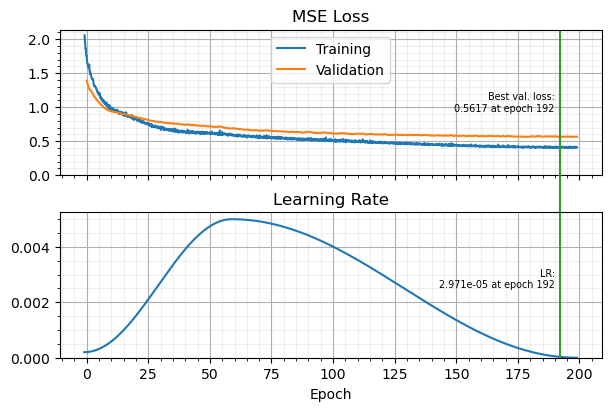

Training on sample 151510
AutoEncoder(
  (encoder): ADDAMLPEncoder(
    (encoder): Sequential(
      (0): Linear(in_features=367, out_features=1024, bias=True)
      (1): BatchNorm1d(1024, eps=0.001, momentum=0.9, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): Dropout(p=0.1, inplace=False)
      (4): Linear(in_features=1024, out_features=512, bias=True)
      (5): BatchNorm1d(512, eps=0.001, momentum=0.9, affine=True, track_running_stats=True)
      (6): LeakyReLU(negative_slope=0.01)
      (7): Dropout(p=0.1, inplace=False)
      (8): Linear(in_features=512, out_features=64, bias=True)
    )
  )
  (decoder): ADDAMLPDecoder(
    (decoder): Sequential(
      (0): Linear(in_features=64, out_features=512, bias=True)
      (1): BatchNorm1d(512, eps=0.001, momentum=0.9, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): Dropout(p=0.1, inplace=False)
      (4): Linear(in_features=512, out_features=1024, bia

Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/8 [00:00<?, ?it/s]

 Epoch | Train Loss | Val Loss   | Next LR    
----------------------------------------------
     0 | 1.89921762 | 1.43608701 | 0.0002033  <-- new best val loss
     1 | 1.62796899 | 1.35886610 | 0.0002132  <-- new best val loss
     2 | 1.51400220 | 1.26608789 | 0.00022967 <-- new best val loss
     3 | 1.41105374 | 1.21161544 | 0.00025266 <-- new best val loss
     4 | 1.31781172 | 1.14100087 | 0.00028212 <-- new best val loss
     5 | 1.24803152 | 1.11501610 | 0.00031795 <-- new best val loss
     6 | 1.18616241 | 1.08450532 | 0.00036007 <-- new best val loss
     7 | 1.12975953 | 1.03747129 | 0.00040835 <-- new best val loss
     8 | 1.07927119 | 1.02007043 | 0.00046266 <-- new best val loss
     9 | 1.03867173 | 0.99399692 | 0.00052285 <-- new best val loss
    10 | 1.00237616 | 0.96499127 | 0.00058876 <-- new best val loss
    11 | 0.97510731 | 0.95895362 | 0.00066021 <-- new best val loss
    12 | 0.95252907 | 0.95575023 | 0.000737   <-- new best val loss
    13 | 0.93585074 | 

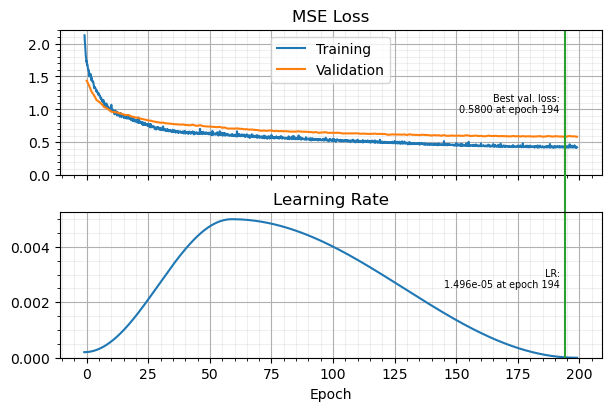

Training on sample 151671
AutoEncoder(
  (encoder): ADDAMLPEncoder(
    (encoder): Sequential(
      (0): Linear(in_features=367, out_features=1024, bias=True)
      (1): BatchNorm1d(1024, eps=0.001, momentum=0.9, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): Dropout(p=0.1, inplace=False)
      (4): Linear(in_features=1024, out_features=512, bias=True)
      (5): BatchNorm1d(512, eps=0.001, momentum=0.9, affine=True, track_running_stats=True)
      (6): LeakyReLU(negative_slope=0.01)
      (7): Dropout(p=0.1, inplace=False)
      (8): Linear(in_features=512, out_features=64, bias=True)
    )
  )
  (decoder): ADDAMLPDecoder(
    (decoder): Sequential(
      (0): Linear(in_features=64, out_features=512, bias=True)
      (1): BatchNorm1d(512, eps=0.001, momentum=0.9, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): Dropout(p=0.1, inplace=False)
      (4): Linear(in_features=512, out_features=1024, bia

Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/7 [00:00<?, ?it/s]

 Epoch | Train Loss | Val Loss   | Next LR    
----------------------------------------------
     0 | 1.93579176 | 1.40266705 | 0.0002033  <-- new best val loss
     1 | 1.66158694 | 1.29929447 | 0.00021321 <-- new best val loss
     2 | 1.53705662 | 1.22528875 | 0.00022969 <-- new best val loss
     3 | 1.43090976 | 1.16694045 | 0.0002527  <-- new best val loss
     4 | 1.33766614 | 1.11855030 | 0.00028217 <-- new best val loss
     5 | 1.26008366 | 1.07867599 | 0.00031802 <-- new best val loss
     6 | 1.18804579 | 1.01743519 | 0.00036016 <-- new best val loss
     7 | 1.12625029 | 0.99307281 | 0.00040847 <-- new best val loss
     8 | 1.07429449 | 0.96594954 | 0.00046281 <-- new best val loss
     9 | 1.03233958 | 0.95198238 | 0.00052304 <-- new best val loss
    10 | 1.00285490 | 0.93613780 | 0.00058899 <-- new best val loss
    11 | 0.97978225 | 0.92713511 | 0.00066048 <-- new best val loss
    12 | 0.96361593 | 0.92165899 | 0.00073731 <-- new best val loss
    13 | 0.94815972 | 

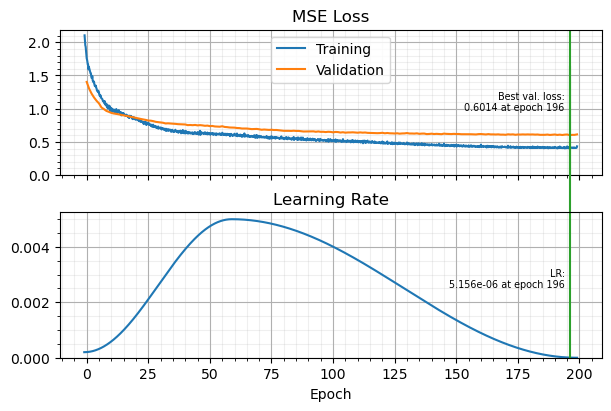

Training on sample 151508
AutoEncoder(
  (encoder): ADDAMLPEncoder(
    (encoder): Sequential(
      (0): Linear(in_features=367, out_features=1024, bias=True)
      (1): BatchNorm1d(1024, eps=0.001, momentum=0.9, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): Dropout(p=0.1, inplace=False)
      (4): Linear(in_features=1024, out_features=512, bias=True)
      (5): BatchNorm1d(512, eps=0.001, momentum=0.9, affine=True, track_running_stats=True)
      (6): LeakyReLU(negative_slope=0.01)
      (7): Dropout(p=0.1, inplace=False)
      (8): Linear(in_features=512, out_features=64, bias=True)
    )
  )
  (decoder): ADDAMLPDecoder(
    (decoder): Sequential(
      (0): Linear(in_features=64, out_features=512, bias=True)
      (1): BatchNorm1d(512, eps=0.001, momentum=0.9, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): Dropout(p=0.1, inplace=False)
      (4): Linear(in_features=512, out_features=1024, bia

Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/7 [00:00<?, ?it/s]

 Epoch | Train Loss | Val Loss   | Next LR    
----------------------------------------------
     0 | 1.89460460 | 1.39398181 | 0.0002033  <-- new best val loss
     1 | 1.64379246 | 1.32231569 | 0.00021321 <-- new best val loss
     2 | 1.53016612 | 1.24177337 | 0.00022969 <-- new best val loss
     3 | 1.43611365 | 1.17149413 | 0.0002527  <-- new best val loss
     4 | 1.34677176 | 1.12638187 | 0.00028217 <-- new best val loss
     5 | 1.27433599 | 1.08916354 | 0.00031802 <-- new best val loss
     6 | 1.21108803 | 1.04883957 | 0.00036016 <-- new best val loss
     7 | 1.15745564 | 1.02183330 | 0.00040847 <-- new best val loss
     8 | 1.10816548 | 0.99174458 | 0.00046281 <-- new best val loss
     9 | 1.06481578 | 0.97980630 | 0.00052304 <-- new best val loss
    10 | 1.02522738 | 0.95105821 | 0.00058899 <-- new best val loss
    11 | 0.99402328 | 0.93967539 | 0.00066048 <-- new best val loss
    12 | 0.96717831 | 0.92651403 | 0.00073731 <-- new best val loss
    13 | 0.94423818 | 

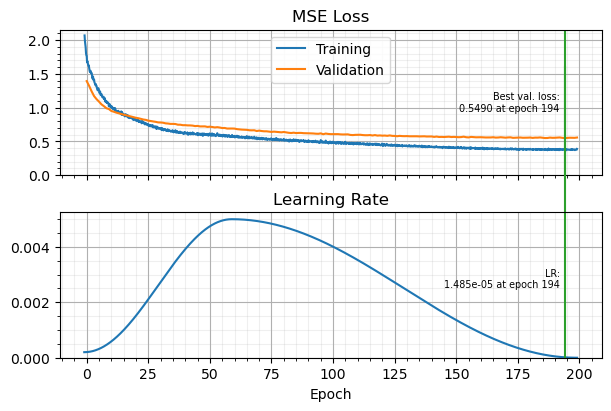

Training on sample 151670
AutoEncoder(
  (encoder): ADDAMLPEncoder(
    (encoder): Sequential(
      (0): Linear(in_features=367, out_features=1024, bias=True)
      (1): BatchNorm1d(1024, eps=0.001, momentum=0.9, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): Dropout(p=0.1, inplace=False)
      (4): Linear(in_features=1024, out_features=512, bias=True)
      (5): BatchNorm1d(512, eps=0.001, momentum=0.9, affine=True, track_running_stats=True)
      (6): LeakyReLU(negative_slope=0.01)
      (7): Dropout(p=0.1, inplace=False)
      (8): Linear(in_features=512, out_features=64, bias=True)
    )
  )
  (decoder): ADDAMLPDecoder(
    (decoder): Sequential(
      (0): Linear(in_features=64, out_features=512, bias=True)
      (1): BatchNorm1d(512, eps=0.001, momentum=0.9, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): Dropout(p=0.1, inplace=False)
      (4): Linear(in_features=512, out_features=1024, bia

Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/6 [00:00<?, ?it/s]

 Epoch | Train Loss | Val Loss   | Next LR    
----------------------------------------------
     0 | 1.92061572 | 1.48572886 | 0.00020331 <-- new best val loss
     1 | 1.67025092 | 1.40208137 | 0.00021322 <-- new best val loss
     2 | 1.56852284 | 1.33384073 | 0.00022971 <-- new best val loss
     3 | 1.48865110 | 1.27492189 | 0.00025274 <-- new best val loss
     4 | 1.40392412 | 1.22080088 | 0.00028223 <-- new best val loss
     5 | 1.32589937 | 1.16419268 | 0.00031811 <-- new best val loss
     6 | 1.26406251 | 1.12294245 | 0.00036029 <-- new best val loss
     7 | 1.21006650 | 1.09352517 | 0.00040863 <-- new best val loss
     8 | 1.16373569 | 1.07475317 | 0.00046302 <-- new best val loss
     9 | 1.11443757 | 1.03771687 | 0.00052329 <-- new best val loss
    10 | 1.07369501 | 1.02545643 | 0.00058929 <-- new best val loss
    11 | 1.03694568 | 0.99582458 | 0.00066083 <-- new best val loss
    12 | 1.00308834 | 0.98343074 | 0.00073772 <-- new best val loss
    13 | 0.97428534 | 

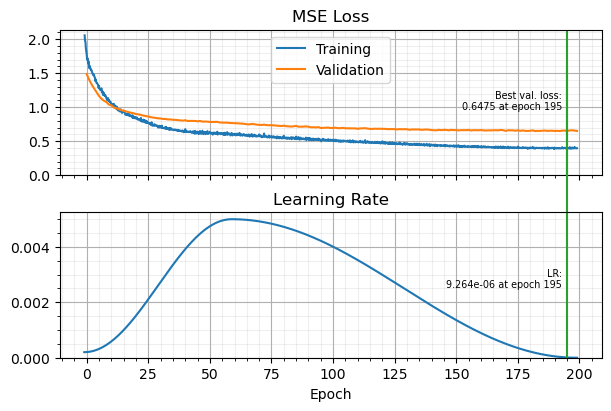

Training on sample 151507
AutoEncoder(
  (encoder): ADDAMLPEncoder(
    (encoder): Sequential(
      (0): Linear(in_features=367, out_features=1024, bias=True)
      (1): BatchNorm1d(1024, eps=0.001, momentum=0.9, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): Dropout(p=0.1, inplace=False)
      (4): Linear(in_features=1024, out_features=512, bias=True)
      (5): BatchNorm1d(512, eps=0.001, momentum=0.9, affine=True, track_running_stats=True)
      (6): LeakyReLU(negative_slope=0.01)
      (7): Dropout(p=0.1, inplace=False)
      (8): Linear(in_features=512, out_features=64, bias=True)
    )
  )
  (decoder): ADDAMLPDecoder(
    (decoder): Sequential(
      (0): Linear(in_features=64, out_features=512, bias=True)
      (1): BatchNorm1d(512, eps=0.001, momentum=0.9, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): Dropout(p=0.1, inplace=False)
      (4): Linear(in_features=512, out_features=1024, bia

Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/7 [00:00<?, ?it/s]

 Epoch | Train Loss | Val Loss   | Next LR    
----------------------------------------------
     0 | 1.92780445 | 1.39508557 | 0.0002033  <-- new best val loss
     1 | 1.65754743 | 1.29239500 | 0.00021321 <-- new best val loss
     2 | 1.53477789 | 1.24612439 | 0.00022969 <-- new best val loss
     3 | 1.43671591 | 1.17669165 | 0.0002527  <-- new best val loss
     4 | 1.34805698 | 1.11722374 | 0.00028217 <-- new best val loss
     5 | 1.27547188 | 1.08511746 | 0.00031802 <-- new best val loss
     6 | 1.21536512 | 1.04601288 | 0.00036016 <-- new best val loss
     7 | 1.15879316 | 1.01138556 | 0.00040847 <-- new best val loss
     8 | 1.11032468 | 0.99998391 | 0.00046281 <-- new best val loss
     9 | 1.06666882 | 0.96597677 | 0.00052304 <-- new best val loss
    10 | 1.02615220 | 0.95142853 | 0.00058899 <-- new best val loss
    11 | 0.99573746 | 0.93425936 | 0.00066048 <-- new best val loss
    12 | 0.96843367 | 0.92460519 | 0.00073731 <-- new best val loss
    13 | 0.94429358 | 

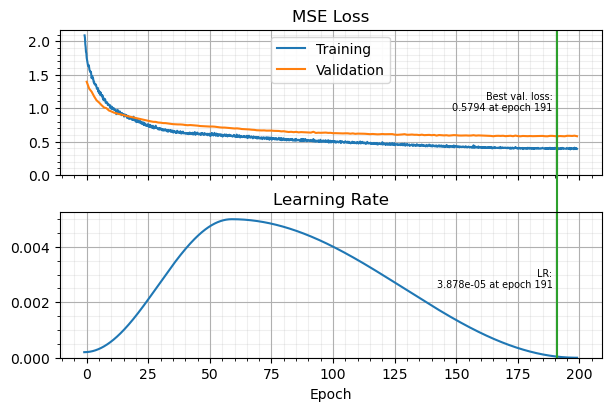

Training on sample 151674
AutoEncoder(
  (encoder): ADDAMLPEncoder(
    (encoder): Sequential(
      (0): Linear(in_features=367, out_features=1024, bias=True)
      (1): BatchNorm1d(1024, eps=0.001, momentum=0.9, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): Dropout(p=0.1, inplace=False)
      (4): Linear(in_features=1024, out_features=512, bias=True)
      (5): BatchNorm1d(512, eps=0.001, momentum=0.9, affine=True, track_running_stats=True)
      (6): LeakyReLU(negative_slope=0.01)
      (7): Dropout(p=0.1, inplace=False)
      (8): Linear(in_features=512, out_features=64, bias=True)
    )
  )
  (decoder): ADDAMLPDecoder(
    (decoder): Sequential(
      (0): Linear(in_features=64, out_features=512, bias=True)
      (1): BatchNorm1d(512, eps=0.001, momentum=0.9, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): Dropout(p=0.1, inplace=False)
      (4): Linear(in_features=512, out_features=1024, bia

Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/6 [00:00<?, ?it/s]

 Epoch | Train Loss | Val Loss   | Next LR    
----------------------------------------------
     0 | 1.93373938 | 1.38095510 | 0.00020331 <-- new best val loss
     1 | 1.65934024 | 1.29075241 | 0.00021322 <-- new best val loss
     2 | 1.53517267 | 1.21540439 | 0.00022971 <-- new best val loss
     3 | 1.44192629 | 1.16152942 | 0.00025274 <-- new best val loss
     4 | 1.35153348 | 1.10351825 | 0.00028223 <-- new best val loss
     5 | 1.26995961 | 1.04732060 | 0.00031811 <-- new best val loss
     6 | 1.20056948 | 1.00773048 | 0.00036029 <-- new best val loss
     7 | 1.13950087 | 0.97621989 | 0.00040863 <-- new best val loss
     8 | 1.08596079 | 0.94960493 | 0.00046302 <-- new best val loss
     9 | 1.03943054 | 0.92815095 | 0.00052329 <-- new best val loss
    10 | 1.00157450 | 0.91298234 | 0.00058929 <-- new best val loss
    11 | 0.97396619 | 0.90024722 | 0.00066083 <-- new best val loss
    12 | 0.95132030 | 0.89191955 | 0.00073772 <-- new best val loss
    13 | 0.93255238 | 

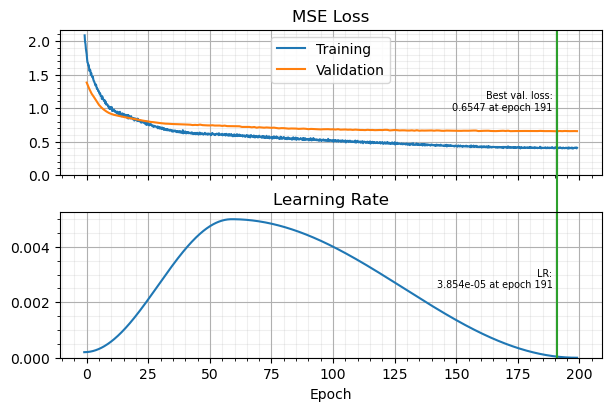

Training on sample 151676
AutoEncoder(
  (encoder): ADDAMLPEncoder(
    (encoder): Sequential(
      (0): Linear(in_features=367, out_features=1024, bias=True)
      (1): BatchNorm1d(1024, eps=0.001, momentum=0.9, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): Dropout(p=0.1, inplace=False)
      (4): Linear(in_features=1024, out_features=512, bias=True)
      (5): BatchNorm1d(512, eps=0.001, momentum=0.9, affine=True, track_running_stats=True)
      (6): LeakyReLU(negative_slope=0.01)
      (7): Dropout(p=0.1, inplace=False)
      (8): Linear(in_features=512, out_features=64, bias=True)
    )
  )
  (decoder): ADDAMLPDecoder(
    (decoder): Sequential(
      (0): Linear(in_features=64, out_features=512, bias=True)
      (1): BatchNorm1d(512, eps=0.001, momentum=0.9, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): Dropout(p=0.1, inplace=False)
      (4): Linear(in_features=512, out_features=1024, bia

Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/6 [00:00<?, ?it/s]

 Epoch | Train Loss | Val Loss   | Next LR    
----------------------------------------------
     0 | 1.92908511 | 1.40868294 | 0.00020331 <-- new best val loss
     1 | 1.67513844 | 1.30278313 | 0.00021322 <-- new best val loss
     2 | 1.55400360 | 1.23000681 | 0.00022971 <-- new best val loss
     3 | 1.46153842 | 1.16646230 | 0.00025274 <-- new best val loss
     4 | 1.37344986 | 1.12632895 | 0.00028223 <-- new best val loss
     5 | 1.29377598 | 1.06703103 | 0.00031811 <-- new best val loss
     6 | 1.22929236 | 1.03971577 | 0.00036029 <-- new best val loss
     7 | 1.17131557 | 0.98937887 | 0.00040863 <-- new best val loss
     8 | 1.11569139 | 0.97315490 | 0.00046302 <-- new best val loss
     9 | 1.07075868 | 0.94909120 | 0.00052329 <-- new best val loss
    10 | 1.03560652 | 0.93622667 | 0.00058929 <-- new best val loss
    11 | 0.99902206 | 0.91677105 | 0.00066083 <-- new best val loss
    12 | 0.97620556 | 0.90629405 | 0.00073772 <-- new best val loss
    13 | 0.95427254 | 

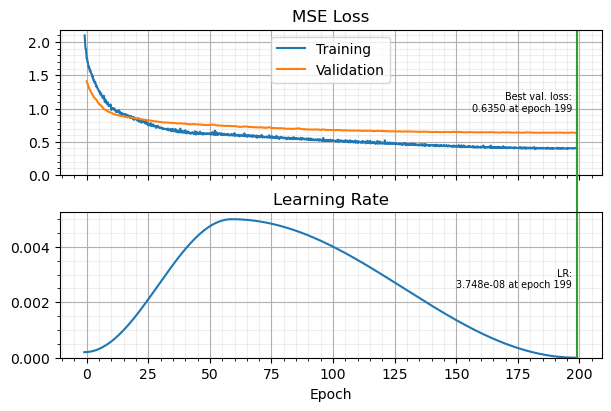

Training on sample 151675
AutoEncoder(
  (encoder): ADDAMLPEncoder(
    (encoder): Sequential(
      (0): Linear(in_features=367, out_features=1024, bias=True)
      (1): BatchNorm1d(1024, eps=0.001, momentum=0.9, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): Dropout(p=0.1, inplace=False)
      (4): Linear(in_features=1024, out_features=512, bias=True)
      (5): BatchNorm1d(512, eps=0.001, momentum=0.9, affine=True, track_running_stats=True)
      (6): LeakyReLU(negative_slope=0.01)
      (7): Dropout(p=0.1, inplace=False)
      (8): Linear(in_features=512, out_features=64, bias=True)
    )
  )
  (decoder): ADDAMLPDecoder(
    (decoder): Sequential(
      (0): Linear(in_features=64, out_features=512, bias=True)
      (1): BatchNorm1d(512, eps=0.001, momentum=0.9, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): Dropout(p=0.1, inplace=False)
      (4): Linear(in_features=512, out_features=1024, bia

Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/6 [00:00<?, ?it/s]

 Epoch | Train Loss | Val Loss   | Next LR    
----------------------------------------------
     0 | 1.95009390 | 1.46991813 | 0.00020331 <-- new best val loss
     1 | 1.67905715 | 1.35658860 | 0.00021322 <-- new best val loss
     2 | 1.55599515 | 1.28710830 | 0.00022971 <-- new best val loss
     3 | 1.46379045 | 1.22762394 | 0.00025274 <-- new best val loss
     4 | 1.37437492 | 1.15228331 | 0.00028223 <-- new best val loss
     5 | 1.29947956 | 1.12985122 | 0.00031811 <-- new best val loss
     6 | 1.22616550 | 1.07349539 | 0.00036029 <-- new best val loss
     7 | 1.16839073 | 1.03447902 | 0.00040863 <-- new best val loss
     8 | 1.11377222 | 0.99743795 | 0.00046302 <-- new best val loss
     9 | 1.06821432 | 0.97390348 | 0.00052329 <-- new best val loss
    10 | 1.02895361 | 0.94934022 | 0.00058929 <-- new best val loss
    11 | 0.99542381 | 0.93313664 | 0.00066083 <-- new best val loss
    12 | 0.97085358 | 0.92089337 | 0.00073772 <-- new best val loss
    13 | 0.94877228 | 

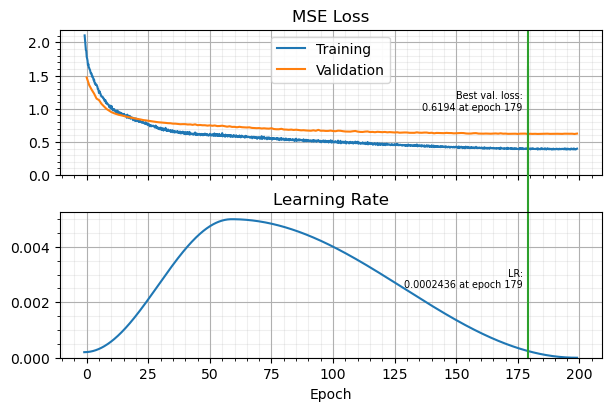

Training on sample 151673
AutoEncoder(
  (encoder): ADDAMLPEncoder(
    (encoder): Sequential(
      (0): Linear(in_features=367, out_features=1024, bias=True)
      (1): BatchNorm1d(1024, eps=0.001, momentum=0.9, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): Dropout(p=0.1, inplace=False)
      (4): Linear(in_features=1024, out_features=512, bias=True)
      (5): BatchNorm1d(512, eps=0.001, momentum=0.9, affine=True, track_running_stats=True)
      (6): LeakyReLU(negative_slope=0.01)
      (7): Dropout(p=0.1, inplace=False)
      (8): Linear(in_features=512, out_features=64, bias=True)
    )
  )
  (decoder): ADDAMLPDecoder(
    (decoder): Sequential(
      (0): Linear(in_features=64, out_features=512, bias=True)
      (1): BatchNorm1d(512, eps=0.001, momentum=0.9, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): Dropout(p=0.1, inplace=False)
      (4): Linear(in_features=512, out_features=1024, bia

Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/6 [00:00<?, ?it/s]

 Epoch | Train Loss | Val Loss   | Next LR    
----------------------------------------------
     0 | 1.91998824 | 1.51571512 | 0.00020331 <-- new best val loss
     1 | 1.65975161 | 1.38882124 | 0.00021322 <-- new best val loss
     2 | 1.53063295 | 1.31925356 | 0.00022971 <-- new best val loss
     3 | 1.42908472 | 1.24215961 | 0.00025274 <-- new best val loss
     4 | 1.34142066 | 1.17261600 | 0.00028223 <-- new best val loss
     5 | 1.25659888 | 1.11400676 | 0.00031811 <-- new best val loss
     6 | 1.18512401 | 1.06853795 | 0.00036029 <-- new best val loss
     7 | 1.12383055 | 1.03029585 | 0.00040863 <-- new best val loss
     8 | 1.07472297 | 1.00311792 | 0.00046302 <-- new best val loss
     9 | 1.03282221 | 0.98113823 | 0.00052329 <-- new best val loss
    10 | 1.00074697 | 0.96610147 | 0.00058929 <-- new best val loss
    11 | 0.97852091 | 0.95458889 | 0.00066083 <-- new best val loss
    12 | 0.95931838 | 0.94270033 | 0.00073772 <-- new best val loss
    13 | 0.94454278 | 

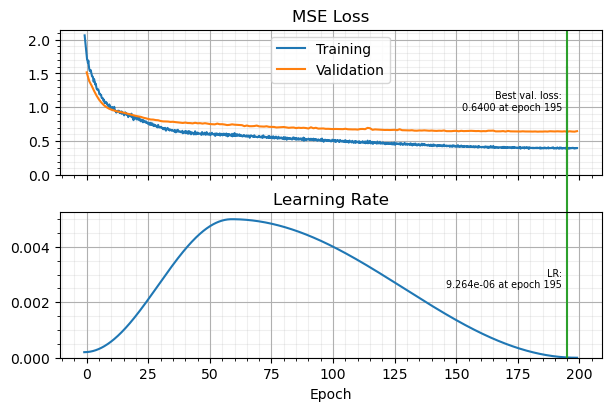

Training on sample 151672
AutoEncoder(
  (encoder): ADDAMLPEncoder(
    (encoder): Sequential(
      (0): Linear(in_features=367, out_features=1024, bias=True)
      (1): BatchNorm1d(1024, eps=0.001, momentum=0.9, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): Dropout(p=0.1, inplace=False)
      (4): Linear(in_features=1024, out_features=512, bias=True)
      (5): BatchNorm1d(512, eps=0.001, momentum=0.9, affine=True, track_running_stats=True)
      (6): LeakyReLU(negative_slope=0.01)
      (7): Dropout(p=0.1, inplace=False)
      (8): Linear(in_features=512, out_features=64, bias=True)
    )
  )
  (decoder): ADDAMLPDecoder(
    (decoder): Sequential(
      (0): Linear(in_features=64, out_features=512, bias=True)
      (1): BatchNorm1d(512, eps=0.001, momentum=0.9, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): Dropout(p=0.1, inplace=False)
      (4): Linear(in_features=512, out_features=1024, bia

Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/7 [00:00<?, ?it/s]

 Epoch | Train Loss | Val Loss   | Next LR    
----------------------------------------------
     0 | 1.90783978 | 1.59416032 | 0.0002033  <-- new best val loss
     1 | 1.64889993 | 1.48285389 | 0.00021321 <-- new best val loss
     2 | 1.53143252 | 1.38495684 | 0.00022969 <-- new best val loss
     3 | 1.42646141 | 1.34611106 | 0.0002527  <-- new best val loss
     4 | 1.33421251 | 1.23027372 | 0.00028217 <-- new best val loss
     5 | 1.25884564 | 1.18218768 | 0.00031802 <-- new best val loss
     6 | 1.18910811 | 1.16276145 | 0.00036016 <-- new best val loss
     7 | 1.13174099 | 1.10158098 | 0.00040847 <-- new best val loss
     8 | 1.08440547 | 1.08119774 | 0.00046281 <-- new best val loss
     9 | 1.04562183 | 1.05024493 | 0.00052304 <-- new best val loss
    10 | 1.01251359 | 1.03440666 | 0.00058899 <-- new best val loss
    11 | 0.99027474 | 1.02759516 | 0.00066048 <-- new best val loss
    12 | 0.97225147 | 1.01420796 | 0.00073731 <-- new best val loss
    13 | 0.95659567 | 

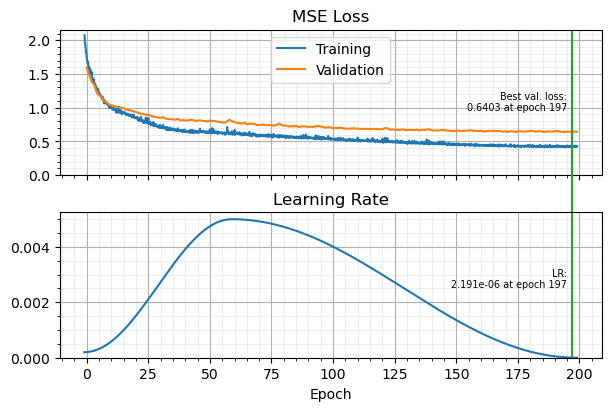

Training on sample 151669
AutoEncoder(
  (encoder): ADDAMLPEncoder(
    (encoder): Sequential(
      (0): Linear(in_features=367, out_features=1024, bias=True)
      (1): BatchNorm1d(1024, eps=0.001, momentum=0.9, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): Dropout(p=0.1, inplace=False)
      (4): Linear(in_features=1024, out_features=512, bias=True)
      (5): BatchNorm1d(512, eps=0.001, momentum=0.9, affine=True, track_running_stats=True)
      (6): LeakyReLU(negative_slope=0.01)
      (7): Dropout(p=0.1, inplace=False)
      (8): Linear(in_features=512, out_features=64, bias=True)
    )
  )
  (decoder): ADDAMLPDecoder(
    (decoder): Sequential(
      (0): Linear(in_features=64, out_features=512, bias=True)
      (1): BatchNorm1d(512, eps=0.001, momentum=0.9, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): Dropout(p=0.1, inplace=False)
      (4): Linear(in_features=512, out_features=1024, bia

Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/6 [00:00<?, ?it/s]

 Epoch | Train Loss | Val Loss   | Next LR    
----------------------------------------------
     0 | 1.96339482 | 1.40037692 | 0.00020331 <-- new best val loss
     1 | 1.69265094 | 1.31047976 | 0.00021322 <-- new best val loss
     2 | 1.57685539 | 1.24024177 | 0.00022971 <-- new best val loss
     3 | 1.48446210 | 1.19783449 | 0.00025274 <-- new best val loss
     4 | 1.40297674 | 1.15600777 | 0.00028223 <-- new best val loss
     5 | 1.32387799 | 1.09087062 | 0.00031811 <-- new best val loss
     6 | 1.25412577 | 1.07279825 | 0.00036029 <-- new best val loss
     7 | 1.18991089 | 1.02869403 | 0.00040863 <-- new best val loss
     8 | 1.13835837 | 0.99770898 | 0.00046302 <-- new best val loss
     9 | 1.08827350 | 0.97856814 | 0.00052329 <-- new best val loss
    10 | 1.05049604 | 0.96102440 | 0.00058929 <-- new best val loss
    11 | 1.01701423 | 0.94532323 | 0.00066083 <-- new best val loss
    12 | 0.98949690 | 0.93605602 | 0.00073772 <-- new best val loss
    13 | 0.97202148 | 

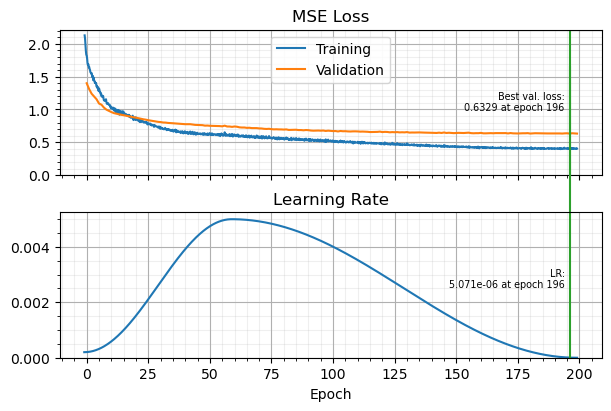

In [10]:
for sample_id in st_sample_id_l:
    print(f"Training on sample {sample_id}")
    save_folder = os.path.join(model_folder, sample_id)
    if not os.path.exists(save_folder):
        os.makedirs(save_folder)

    # Model Initialization
    model = AutoEncoder(
        inp_dim=mat_sp_train_s_d[sample_id].shape[1], **autoencoder_kwargs
    )
    model = model.to(device)
    model.apply(initialize_weights)
    print(model)

    # Using an Adam Optimizer with lr = 0.1
    optimizer = torch.optim.AdamW(model.parameters(), **adamw_kwargs)

    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=INITIAL_TRAIN_LR,
        steps_per_epoch=len(dataloader_target_train_d[sample_id]),
        epochs=INITIAL_TRAIN_EPOCHS,
    )

    # AMP Scaler
    scaler = GradScaler()

    # Initialize lists to store loss and accuracy values
    loss_history = []
    loss_history_val = []

    loss_history_running = []

    lr_history_running = []

    # Early Stopping
    best_loss_val = np.inf
    early_stop_count = 0

    # Train
    with DupStdout().dup_to_file(os.path.join(save_folder, "log.txt"), "w") as f_log:
        print("Start train...")
        outer = tqdm(total=INITIAL_TRAIN_EPOCHS, desc="Epochs", position=0)
        inner = tqdm(
            total=len(dataloader_target_train_d[sample_id]), desc=f"Batch", position=1
        )

        print(" Epoch | Train Loss | Val Loss   | Next LR    ")
        print("----------------------------------------------")
        checkpoint = {
            "epoch": -1,
            "model": model,
            "optimizer": optimizer,
            "scheduler": scheduler,
            "scaler": scaler,
        }
        for epoch in range(INITIAL_TRAIN_EPOCHS):
            checkpoint["epoch"] = epoch

            # Train mode
            model.train()
            inner.refresh()  # force print final state
            inner.reset()  # reuse bar

            avg_results, running_results = run_epoch(
                dataloader_target_train_d[sample_id],
                model,
                optimizer=optimizer,
                scheduler=scheduler,
                scaler=scaler,
                inner=inner,
            )

            loss_history.append(avg_results["loss"])
            loss_history_running.append(running_results["loss"])
            lr_history_running.append(running_results["lr"])

            # Evaluate mode
            model.eval()
            with torch.no_grad():
                avg_results_val, running_results_val = run_epoch(
                    dataloader_target_val_d[sample_id], model
                )
            loss_history_val.append(avg_results_val["loss"])

            # Print the results
            outer.update(1)

            print(
                f" {epoch:5d}",
                f"| {avg_results['loss']:<10.8f}",
                f"| {avg_results_val['loss']:<10.8f}",
                f"| {scheduler.get_last_lr()[-1]:<10.5}",
                end=" ",
            )

            # Save the best weights
            if avg_results_val["loss"] < best_loss_val:
                best_loss_val = avg_results_val["loss"]
                torch.save(checkpoint, os.path.join(save_folder, f"best_model.pth"))
                early_stop_count = 0

                print("<-- new best val loss")
            else:
                print("")

            # Save checkpoint every 10
            if epoch % 10 == 0 or epoch >= INITIAL_TRAIN_EPOCHS - 1:
                torch.save(
                    checkpoint, os.path.join(save_folder, f"checkpt{epoch}.pth")
                )

            # check to see if validation loss has plateau'd
            if early_stop_count >= EARLY_STOP_CRIT and epoch >= MIN_EPOCHS - 1:
                print(
                    f"Validation loss plateaued after {early_stop_count} at epoch {epoch}"
                )
                torch.save(
                    checkpoint, os.path.join(save_folder, f"earlystop{epoch}.pth")
                )
                break

            early_stop_count += 1

    lr_history_running[-1].append(scheduler.get_last_lr()[-1])

    # Save final model
    best_checkpoint = torch.load(
        os.path.join(save_folder, f"best_model.pth")
    )
    torch.save(
        best_checkpoint, os.path.join(save_folder, f"final_model.pth")
    )

    best_checkpoint = torch.load(
        os.path.join(save_folder, f"final_model.pth")
    )

    best_epoch = best_checkpoint["epoch"]
    best_loss_val = loss_history_val[best_epoch]

    fig, axs = plt.subplots(2, 1, sharex=True, figsize=(6, 4), layout="constrained")

    plot_iters(loss_history_running, ax=axs[0], label="Training")
    axs[0].plot(loss_history_val, label="Validation")
    axs[0].axvline(best_epoch, color="tab:green")

    axs[0].set_ylim(bottom=0)
    axs[0].grid(which="major")
    axs[0].minorticks_on()
    axs[0].grid(which="minor", alpha=0.2)

    axs[0].text(
        x=best_epoch + (2 if best_epoch < len(loss_history) * 0.75 else -2),
        y=max(loss_history + loss_history_val) * 0.5,
        s=f"Best val. loss:\n{best_loss_val:.4f} at epoch {best_epoch}",
        ha="left" if best_epoch < len(loss_history) * 0.75 else "right",
        size="x-small",
    )

    axs[0].set_title("MSE Loss")
    axs[0].legend()

    # lr history
    iters_by_epoch, lr_history_running_flat = plot_iters(
        lr_history_running, startpoint=True, ax=axs[1]
    )
    axs[1].axvline(best_checkpoint["epoch"], ymax=2, clip_on=False, color="tab:green")

    axs[1].set_ylim(bottom=0)
    axs[1].grid(which="major")
    axs[1].minorticks_on()
    axs[1].grid(which="minor", alpha=0.2)

    best_epoch_idx = np.where(iters_by_epoch == best_epoch)[0][0]
    axs[1].text(
        x=best_epoch + (2 if best_epoch < len(loss_history) * 0.75 else -2),
        y=np.median(lr_history_running_flat),
        s=f"LR:\n{lr_history_running_flat[best_epoch_idx]:.4} at epoch {best_epoch}",
        ha="left" if best_epoch < len(loss_history) * 0.75 else "right",
        size="x-small",
    )

    axs[1].set_xlabel("Epoch")
    axs[1].set_title("Learning Rate")

    plt.savefig(
        os.path.join(save_folder, "train_plots.png"), bbox_inches="tight"
    )

    plt.show(block=False)


In [11]:
dataloader_target_val_d.keys()

dict_keys(['151509', '151510', '151671', '151508', '151670', '151507', '151674', '151676', '151675', '151673', '151672', '151669'])

In [12]:
import pandas as pd

for sample_id in st_sample_id_l:
    best_checkpoint = torch.load(
        os.path.join(model_folder, sample_id, f"final_model.pth")
    )
    model = best_checkpoint["model"]
    model.to(device)
    model.eval()
    with torch.no_grad():
        avg_results_train, running_results_train = run_epoch(
            dataloader_target_train_d[sample_id], model
        )
        avg_results_val, running_results_val = run_epoch(
            dataloader_target_val_d[sample_id], model
        )
        avg_results_test, running_results_test = run_epoch(
            dataloader_target_test_d[sample_id], model
        )

    print(
        pd.concat(
            [
                pd.Series(avg_results_train).to_frame().T,
                pd.Series(avg_results_val).to_frame().T,
                pd.Series(avg_results_test).to_frame().T,
            ],
            keys=["train", "val", "test"],
        ).loss
    )


train  0    0.342132
val    0    0.561721
test   0    0.561082
Name: loss, dtype: float64
train  0    0.361348
val    0    0.579970
test   0    0.576972
Name: loss, dtype: float64
train  0    0.339166
val    0    0.601427
test   0    0.603989
Name: loss, dtype: float64
train  0    0.306270
val    0    0.549028
test   0    0.541799
Name: loss, dtype: float64
train  0    0.322455
val    0    0.647547
test   0    0.626447
Name: loss, dtype: float64
train  0    0.329313
val    0    0.579446
test   0    0.594082
Name: loss, dtype: float64
train  0    0.333966
val    0    0.654699
test   0    0.649130
Name: loss, dtype: float64
train  0    0.329978
val    0    0.634952
test   0    0.641145
Name: loss, dtype: float64
train  0    0.323713
val    0    0.619446
test   0    0.629593
Name: loss, dtype: float64
train  0    0.327323
val    0    0.640032
test   0    0.644876
Name: loss, dtype: float64
train  0    0.357522
val    0    0.640345
test   0    0.656614
Name: loss, dtype: float64
train  0  

In [13]:
(pd.DataFrame(mat_sp_train_s_d[sample_id]).mean()).mean()


-2.147848343625469e-09

In [14]:
dataloader_target_train_d[sample_id]